### Notas de aula de Computação Quântica <br> Autor: Jonas Maziero

# Usando as simetrias do hamiltoniano
Para 
\begin{equation}
H_{xxx} = J\sum_{\langle j,k\rangle}\big(\sigma_{j}^{x}\sigma_{k}^{x}+\sigma_{j}^{y}\sigma_{k}^{y}+\sigma_{j}^{z}\sigma_{k}^{z}\big)
\end{equation} 
e 
\begin{equation}
S_{d} := \frac{1}{2}\sum_{j=1}^{N}\sigma_{j}^{d}
\end{equation}
com $d=x,y,z$, temos que
\begin{equation}
[H_{xxx},S_{x}] = [H_{xxx},S_{y}] = [H_{xxx},S_{z}] =0.
\end{equation}
Lembremos que 
\begin{equation}
H_{xxx} = H_{xxx}^{(12)} + H_{xxx}^{(23)},
\end{equation}
com (para três spins, $H_{xxx}^{(3)}$)
\begin{equation}
H_{xxx}^{(12)} = (X\otimes X+Y\otimes Y+Z\otimes Z)\otimes I = H_{xxx}^{(2)}\otimes I
\end{equation}
e
\begin{equation}
H_{xxx}^{(23)} = I\otimes(X\otimes X+Y\otimes Y+Z\otimes Z) = I\otimes H_{xxx}^{(2)}.
\end{equation}
Lembremos também que
\begin{equation}
U = e^{-iH_{xxx}t} = e^{-i(H_{xxx}^{12}+H_{xxx}^{23})t} = \lim_{j\rightarrow\infty}\Big(e^{-iH_{xxx}^{12}t/j}e^{-iH_{xxx}^{23}t/j}\Big)^{j}
\end{equation}
e que aproximamos a relação exata usando um número finito $j=n_{pt}$ de passos de Trotter.

Nesse ponto, não é difícil notar que não é a simetria em relação a $H_{xxx}$ que devemos usar na prática, mas sim a simetria em relação a $H_{xxx}^{(12)}$ e $H_{xxx}^{(23)}$. Usando os resultados listados acima, se definirmos
\begin{equation}
S_{d}^{(jk)} = \sigma_{j}^{d} + \sigma_{k}^{d},
\end{equation}
teremos que
\begin{equation}
[H_{xxx}^{(jk)},S_{d}^{(jk)}] = 0 \text{ para }j,k=1,2 \text{ e } j,k=23.
\end{equation}
Explicitamente
\begin{equation}
[X\otimes I+I\otimes X, H_{xxx}^{(jk)}] = [Y\otimes I+I\otimes Y, H_{xxx}^{(jk)}] = [Z\otimes I+I\otimes Z, H_{xxx}^{(jk)}] = 0.
\end{equation}

Teremos assim, por exemplo, que
\begin{equation}
e^{-iH_{xxx}^{(jk)}t/j} = \big(e^{iZ\phi}\otimes e^{iZ\phi}\big)e^{-iH_{xxx}^{(jk)}t/j}\big(e^{-iZ\phi}\otimes e^{-iZ\phi}\big),
\end{equation}
em que usamos que 
\begin{equation}
e^{\pm i(Z\otimes I+ I\otimes Z)\phi} = e^{\pm i(Z\otimes I)\phi}e^{\pm i(I\otimes Z)\phi} = \big(e^{\pm iZ\phi}\otimes I\big)\big(I\otimes e^{\pm iZ\phi}\big) = e^{iZ\phi}\otimes e^{iZ\phi}.
\end{equation}

A operação básica da troterização é
\begin{equation}
B_{j} = \Big(e^{-iH_{xxx}^{(2)}t/j}\otimes I\Big)\Big(I\otimes e^{-iH_{xxx}^{(2)}t/j}\Big).
\end{equation}
Podemos usar as transformações de simetria
\begin{equation}
B_{j} = \Big(e^{iZ\phi}\otimes e^{iZ\phi}\otimes I\Big)\Big(e^{-iH_{xxx}^{(2)}t/j}\otimes I\Big)\Big(e^{-iZ\phi}\otimes e^{-iZ\phi}\otimes I\Big)\Big(I\otimes e^{iX\theta}\otimes e^{iX\theta}\Big)\Big(I\otimes e^{-iH_{xxx}^{(2)}t/j}\Big)\Big(I\otimes e^{-iX\theta}\otimes e^{-iX\theta}\Big).
\end{equation}
Claro, podemos utilizar várias outras combinações de transformações de simetria. Vale mencionar que se usamos e.g. $Z$ e $Z$ para os dois pares de spins, se cancelam ou se somanda para o spin do meio, dependendo da escolha do sinal da fase.

Para a sequência, é válido fazer um estudo da dependência da fidelidade com a escolha da sequência de simetrias e também com os valores dos ângulos.

In [35]:
nshots = 500; 
Npt = 7 # Número de passos de Trotter 
ph = 2*math.pi # ângulo para a transformação de simetria
t = math.pi
for j in range(0, Npt): # muda o No. de passos de Trotter
    # teórico
    U12 = UHxxx12_num(t/(j+1)); U23 = UHxxx23_num(t/(j+1))
    B = np.dot(U12, U23); U = np.linalg.matrix_power(B, j+1); psit = np.dot(U, psi0_)
    F_teo = qiskit.quantum_info.state_fidelity(psi0_, psit)
    # circuit q
    qc = QuantumCircuit(3)
    qc_psi0_ = qc_psi0(); qc.append(qc_psi0_, [0, 1, 2]) # estado inicial 
    qc_Bj_ = qc_Bj(t/(j+1))
    for k in range(0, j+1):
        qc.rz(ph/(j+1), [0, 1, 2]) # transformação de simetria
        qc.append(qc_Bj_, [0, 1, 2])
    qc.rz(-ph, [0, 1, 2]) # revertendo a transformação de simetria
    if j == 1:
        qc.draw(output = 'mpl')
    qstc = state_tomography_circuits(qc, [0, 1, 2])
    # simulação
    job = qiskit.execute(qstc, backend = simulator, shots = nshots)
    qstf = StateTomographyFitter(job.result(), qstc)
    rho = qstf.fit(method = 'lstsq')
    F_sim = qiskit.quantum_info.state_fidelity(psi0__, rho)
    # experimento
    jobE = qiskit.execute(qstc, backend = device, shots = nshots)
    print(jobE.job_id()); job_monitor(jobE)
    qstfE = StateTomographyFitter(jobE.result(), qstc)
    rhoE = qstfE.fit(method = 'lstsq')
    F_exp = qiskit.quantum_info.state_fidelity(psi0__, rhoE)
    print('No. passos=', j+1, ',F_teo=', F_teo, ',F_sim=', F_sim, ',F_exp=', F_exp)

61eeb8d21faa066ac33471ac
Job Status: job has successfully run
No. passos= 1 ,F_teo= 0.9999999999999982 ,F_sim= 0.9835439866736209 ,F_exp= 0.8693340150654622
61eeba0a404aae6cc54398f9
Job Status: job has successfully run
No. passos= 2 ,F_teo= 0.9999999999999982 ,F_sim= 0.9828191225149983 ,F_exp= 0.3463818998642021
61eebab86fb79788a44438e3
Job Status: job has successfully run
No. passos= 3 ,F_teo= 0.07714843750000015 ,F_sim= 0.07860760713526703 ,F_exp= 0.1277385074185349
61eebae34eebda70647a9eeb
Job Status: job has successfully run
No. passos= 4 ,F_teo= 5.058650151352797e-31 ,F_sim= 0.005374151286554848 ,F_exp= 0.15742657473680358
61eebb2cd6c095a34bdfc2c6
Job Status: job has successfully run
No. passos= 5 ,F_teo= 0.25686109467744184 ,F_sim= 0.2504194180680803 ,F_exp= 0.15878393105662453
61eebba99847b3b227ab22f2
Job Status: job has successfully run
No. passos= 6 ,F_teo= 0.5732133388519284 ,F_sim= 0.5564887023558757 ,F_exp= 0.16294519364889065
61eebbe9dfe4a9167822efb2
Job Status: job has su

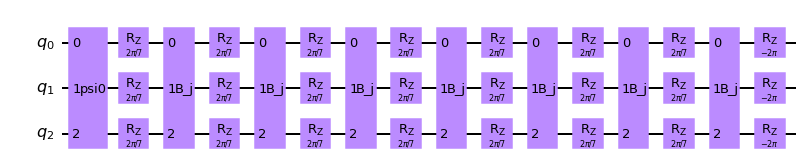

In [37]:
qc.draw(output = 'mpl')